In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'gan-getting-started:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F21755%2F1475600%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240223%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240223T022448Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D794770a6faf1435383d4bcd606a25d38d818bb7c697ac6cd64d1f5d10b4c37a12af714647b95ba572390fc6bfdc75648f64df821979ef48e4bc9ca3a785d5f964fe26bd7ae6ace788e76ec816e929769553477b1095584c0fa22c8f3f41e8feb30764309c00381138c4f73cff55fcad8fc4b7a6fce5c92c1faa50d7f2ee08abecf7c8127902c3ae70b0253544af5c5eb82700478c91116381032820ad498f90599bccab2946953d2e0fe3b3f7fee46912452c8c214af24ff5c274c2280be0271d76226870845aa45007235d9691d15e557aeb0bc4799f1c65dc0ac6741a61d84682d4dd7ac6a4ca6b55097defd5c6ad3e5812b8903440ce096b10d5135e4b613'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 384799057 bytes downloaded
Downloaded and uncompressed: gan-getting-started
Data source import complete.


# Monet Cycle GAN Project

### Load neccesary Libraries

In [2]:
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import os
from PIL import Image

## Data Inspection

visualize sample images

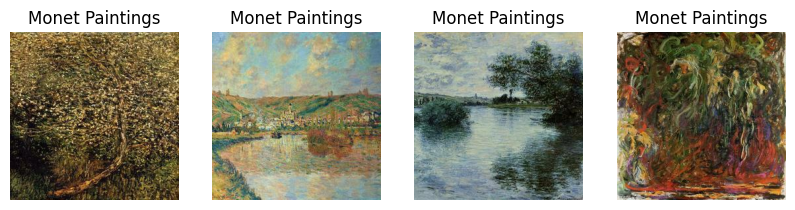

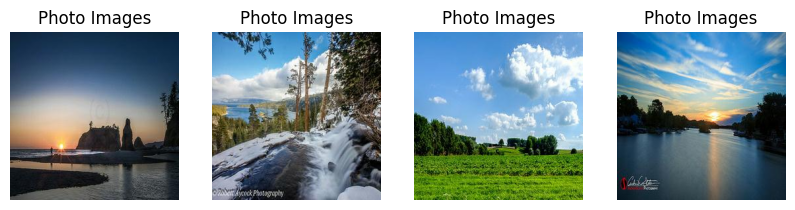

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import random

def show_sample_images(image_paths, title, num_samples=4):
    plt.figure(figsize=(10, num_samples * 2.5))
    for i in range(num_samples):
        img_path = random.choice(image_paths)
        img = Image.open(img_path)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(title)
        plt.axis("off")
    plt.show()

monet_paths = ['/kaggle/input/gan-getting-started/monet_jpg/' + f for f in os.listdir('/kaggle/input/gan-getting-started/monet_jpg')]
photo_paths = ['/kaggle/input/gan-getting-started/photo_jpg/' + f for f in os.listdir('/kaggle/input/gan-getting-started/photo_jpg')]

show_sample_images(monet_paths, "Monet Paintings")
show_sample_images(photo_paths, "Photo Images")


analyze photo distribution

In [4]:
import numpy as np

def analyze_image_stats(image_paths):
    colors = np.zeros((len(image_paths), 3))
    brightness = np.zeros(len(image_paths))

    for i, img_path in enumerate(image_paths):
        img = np.array(Image.open(img_path))
        colors[i, :] = np.mean(img, axis=(0, 1))  # Average color
        brightness[i] = np.mean(img)  # Average brightness

    return colors, brightness

monet_colors, monet_brightness = analyze_image_stats(monet_paths)
photo_colors, photo_brightness = analyze_image_stats(photo_paths)

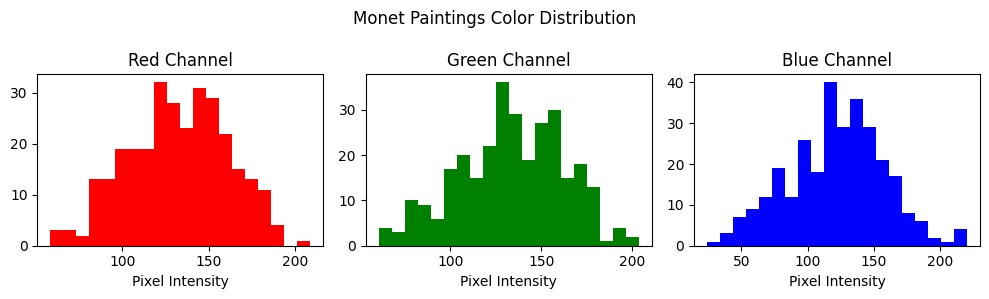

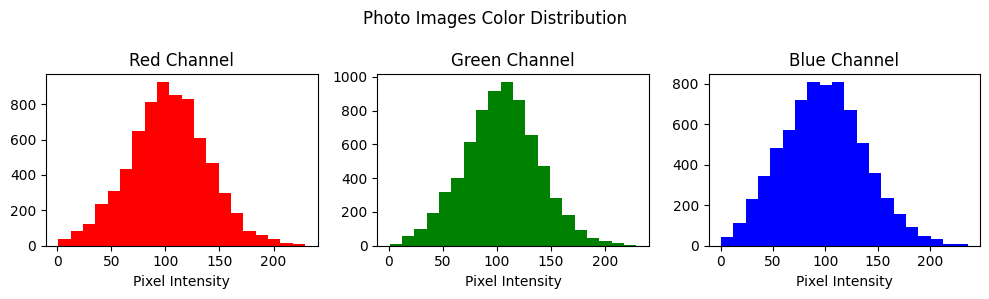

In [5]:
import matplotlib.pyplot as plt

def plot_color_distributions(colors, title):
    plt.figure(figsize=(10, 3))
    labels = ['Red Channel', 'Green Channel', 'Blue Channel']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.hist(colors[:, i], bins=20, color=labels[i].split()[0].lower())
        plt.title(f'{labels[i]}')
        plt.xlabel('Pixel Intensity')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_color_distributions(monet_colors, 'Monet Paintings Color Distribution')
plot_color_distributions(photo_colors, 'Photo Images Color Distribution')


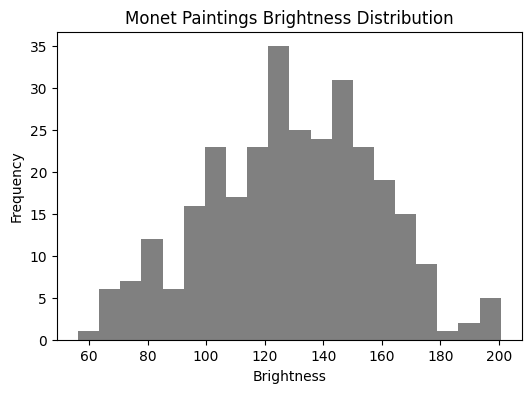

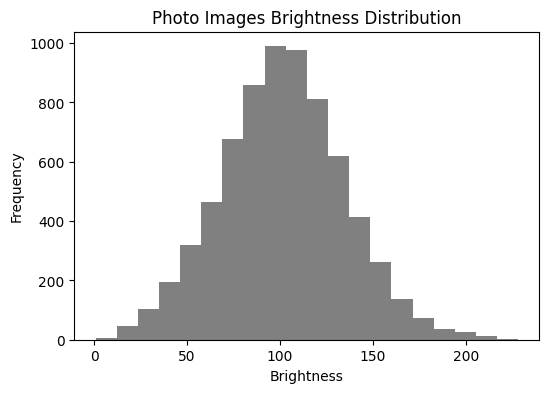

In [6]:
def plot_brightness_distribution(brightness, title):
    plt.figure(figsize=(6, 4))
    plt.hist(brightness, bins=20, color='gray')
    plt.title(f'{title} Brightness Distribution')
    plt.xlabel('Brightness')
    plt.ylabel('Frequency')
    plt.show()

plot_brightness_distribution(monet_brightness, 'Monet Paintings')
plot_brightness_distribution(photo_brightness, 'Photo Images')


photo resolution and aspect ratio

In [7]:
def analyze_image_resolutions(image_paths):
    resolutions = np.zeros((len(image_paths), 2), dtype=int)

    for i, img_path in enumerate(image_paths):
        img = Image.open(img_path)
        resolutions[i, :] = img.size

    return resolutions

monet_resolutions = analyze_image_resolutions(monet_paths)
photo_resolutions = analyze_image_resolutions(photo_paths)

In [8]:
def summarize_resolutions(resolutions):
    widths = resolutions[:, 0]
    heights = resolutions[:, 1]
    print(f"Width - Mean: {np.mean(widths):.2f}, Median: {np.median(widths)}, Min: {np.min(widths)}, Max: {np.max(widths)}")
    print(f"Height - Mean: {np.mean(heights):.2f}, Median: {np.median(heights)}, Min: {np.min(heights)}, Max: {np.max(heights)}")

print("Monet Paintings Resolutions:")
summarize_resolutions(monet_resolutions)

print("\nPhoto Images Resolutions:")
summarize_resolutions(photo_resolutions)


Monet Paintings Resolutions:
Width - Mean: 256.00, Median: 256.0, Min: 256, Max: 256
Height - Mean: 256.00, Median: 256.0, Min: 256, Max: 256

Photo Images Resolutions:
Width - Mean: 256.00, Median: 256.0, Min: 256, Max: 256
Height - Mean: 256.00, Median: 256.0, Min: 256, Max: 256


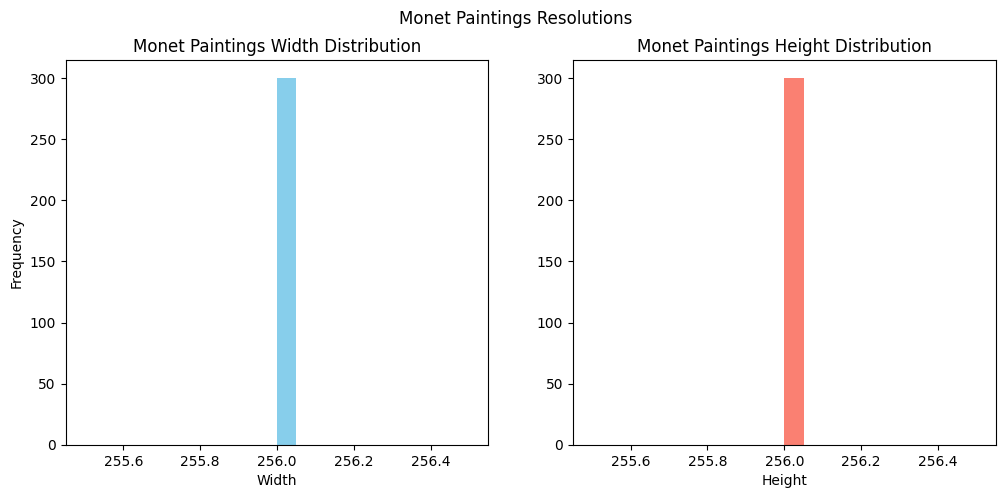

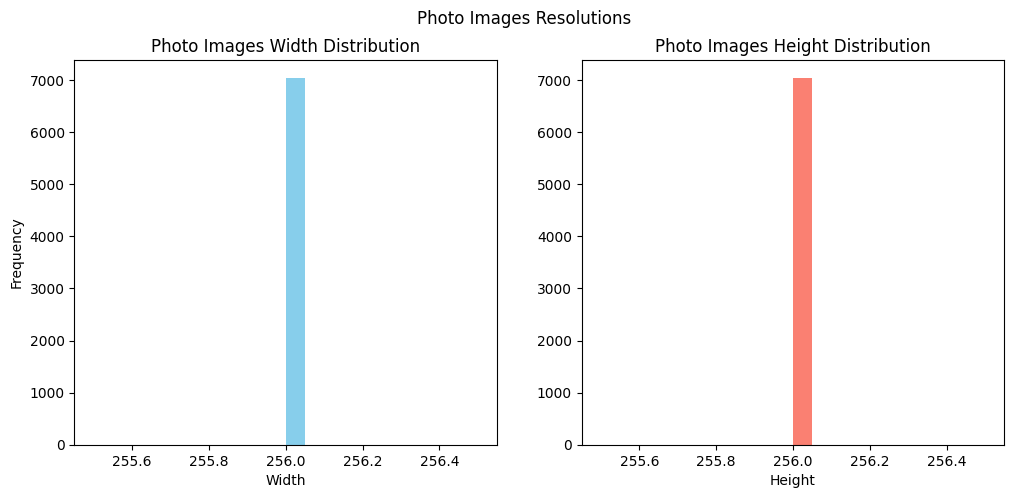

In [9]:
def plot_resolution_distributions(resolutions, title):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(resolutions[:, 0], bins=20, color='skyblue')
    plt.title(f'{title} Width Distribution')
    plt.xlabel('Width')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(resolutions[:, 1], bins=20, color='salmon')
    plt.title(f'{title} Height Distribution')
    plt.xlabel('Height')

    plt.suptitle(f'{title} Resolutions')
    plt.show()

plot_resolution_distributions(monet_resolutions, 'Monet Paintings')
plot_resolution_distributions(photo_resolutions, 'Photo Images')


Descriptive Statistics

In [10]:
def print_statistics(data, label):
    print(f"{label} - Mean: {np.mean(data, axis=0)}, StdDev: {np.std(data, axis=0)}")

print_statistics(monet_colors, "Monet Colors")
print_statistics(photo_colors, "Photo Colors")
print_statistics(monet_brightness, "Monet Brightness")
print_statistics(photo_brightness, "Photo Brightness")
print_statistics(monet_resolutions, "Monet Resolutions")
print_statistics(photo_resolutions, "Photo Resolutions")


Monet Colors - Mean: [132.96300456 133.72787954 121.57267919], StdDev: [28.7084933  28.94878411 36.05906556]
Photo Colors - Mean: [102.96808675 104.1944681   97.92882523], StdDev: [36.37039711 34.62688313 39.16809604]
Monet Brightness - Mean: 129.42118776109484, StdDev: 28.684083779719096
Photo Brightness - Mean: 101.69712669370391, StdDev: 33.397823240506355
Monet Resolutions - Mean: [256. 256.], StdDev: [0. 0.]
Photo Resolutions - Mean: [256. 256.], StdDev: [0. 0.]


## Define Datasets
### Implement custom PyTorch datasets for both the Monet paintings and the photo images. These datasets will handle loading and preprocessing (resizing, normalizing) the images.

In [11]:
import os

class ImageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.files = [os.path.join(root, f) for f in os.listdir(root) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        filename = os.path.basename(img_path)
        return image, filename

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

monet_dataset = ImageDataset("/kaggle/input/gan-getting-started/monet_jpg", transform=transform)
photo_dataset = ImageDataset("/kaggle/input/gan-getting-started/photo_jpg", transform=transform)


## Architecture Components
Two Generators:

- G: Translates images from domain A to domain B.
- F: Translates images from domain B to domain A.
Each generator typically incorporates a series of convolutional layers for downsampling, followed by residual blocks, and then convolutional transpose layers for upsampling.

Two Discriminators:

- D_A: Discriminates between real images from domain A and fake images generated by F.
- D_B: Discriminates between real images from domain B and fake images generated by G.
Discriminators often use a PatchGAN architecture, which classifies patches of the image as real or fake, enabling the model to focus on high-frequency details.

## Define the Generator and Discriminator Models

ResidualBlock: A key component of the ResNet generator, implementing a convolutional block with a residual connection. It helps the network learn identity functions, which is beneficial for deep networks by mitigating the vanishing gradient problem.

ResnetGenerator: The generator starts with an initial convolution to increase the feature depth, followed by downsampling to a lower resolution. A series of residual blocks enables the network to learn complex transformations. Finally, the network upsamples back to the original resolution and concludes with a tanh activation to output an image.

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    """Implements a single block in the ResNet generator"""
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        # Residual connection
        return x + self.block(x)

class ResnetGenerator(nn.Module):
    """Defines the ResNet-based generator model"""
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(ResnetGenerator, self).__init__()

        # Initial convolution block
        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, 64, 7),
                 nn.InstanceNorm2d(64),
                 nn.ReLU(inplace=True)]

        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                      nn.InstanceNorm2d(out_features),
                      nn.ReLU(inplace=True)]
            in_features = out_features
            out_features = in_features*2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features//2
        for _ in range(2):
            model += [nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                      nn.InstanceNorm2d(out_features),
                      nn.ReLU(inplace=True)]
            in_features = out_features
            out_features = in_features//2

        # Output layer
        model += [nn.ReflectionPad2d(3),
                  nn.Conv2d(64, output_nc, 7),
                  nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


PatchGANDiscriminator: The discriminator uses a series of convolutions to progressively downsample the input image, focusing on 70x70 patches. Each convolutional layer, except the first, is followed by instance normalization and a leaky ReLU activation. The final convolution outputs a single channel used for real vs. fake classification of patches.

In [13]:
class PatchGANDiscriminator(nn.Module):
    """Defines the PatchGAN discriminator model"""
    def __init__(self, input_nc):
        super(PatchGANDiscriminator, self).__init__()

        # PatchGAN discriminator model
        self.model = nn.Sequential(
            nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, padding=1)  # Output 1 channel for real/fake classification
        )

    def forward(self, x):
        return self.model(x)


initialize cycle gan components

In [14]:
# Initialize Generator and Discriminator Models for CycleGAN

# For RGB images, input_nc = output_nc = 3
input_nc = 3
output_nc = 3
n_residual_blocks = 9  # Common choice for generators in CycleGAN

# Initialize Generators
generator_G = ResnetGenerator(input_nc=input_nc, output_nc=output_nc, n_residual_blocks=n_residual_blocks)
generator_F = ResnetGenerator(input_nc=output_nc, output_nc=input_nc, n_residual_blocks=n_residual_blocks)

# Initialize Discriminators
discriminator_A = PatchGANDiscriminator(input_nc=input_nc)
discriminator_B = PatchGANDiscriminator(input_nc=output_nc)

# Check if CUDA is available and move models to GPU if it is
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
generator_G.to(device)
generator_F.to(device)
discriminator_A.to(device)
discriminator_B.to(device)


PatchGANDiscriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

## Define the Loss Functions and Optimizers

In [15]:
from torch.optim import Adam

# Loss functions
adversarial_loss = torch.nn.MSELoss().to(device)
cycle_consistency_loss = torch.nn.L1Loss().to(device)
identity_loss = torch.nn.L1Loss().to(device)

# Optimizers
# Learning rate for Adam
lr = 0.0002
# Beta1 & Beta2 hyperparameters for Adam optimizers
beta1 = 0.5
beta2 = 0.999

# Create optimizers for the generators and discriminators
G_optimizer = Adam(list(generator_G.parameters()) + list(generator_F.parameters()), lr=lr, betas=(beta1, beta2))
D_optimizer = Adam(list(discriminator_A.parameters()) + list(discriminator_B.parameters()), lr=lr, betas=(beta1, beta2))


In [16]:
num_epochs = 50
lambda_cycle = 10  # Weight for cycle consistency loss

from torch.utils.data import DataLoader

# Create DataLoaders for Monet paintings and photo images
batch_size = 1  # CycleGAN typically uses a batch size of 1 due to the instance normalization

monet_loader = DataLoader(monet_dataset, batch_size=batch_size, shuffle=True)
photo_loader = DataLoader(photo_dataset, batch_size=batch_size, shuffle=True)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Training Loop

Adversarial Loss: Ensures that generated images (fake photos and fake Monet paintings) are indistinguishable from real ones by the discriminators.

Cycle Consistency Loss: Minimizes the difference between the original images and the ones that have undergone a round-trip transformation (A → B → A and B → A → B), helping the model to maintain content while altering style.

Lambda Cycle: lambda_cycle is a hyperparameter that controls the importance of the cycle consistency loss relative to the adversarial loss. It's common to set this to a value like 10 to emphasize the importance of cycle consistency.

Detaching Fake Images for Discriminator Training: When calculating the discriminator losses, detach() is used on the fake images to ensure that the gradients are not backpropagated through the generators at this step.

Gradient Zeroing: It's crucial to zero the gradients of both optimizers at the beginning of each iteration to prevent accumulation of gradients from multiple forward passes.

Device Assignment: Ensure all tensors are moved to the correct device (CPU/GPU) as defined by device.

In [17]:
# Training loop for CycleGAN
for epoch in range(num_epochs):
    for monet, photo in zip(monet_loader, photo_loader):
        # Move inputs to the correct device
        """images is moved to the designated computing device (GPU or CPU).
        This step is crucial for leveraging GPU acceleration during training."""
        real_A = monet[0].to(device)
        real_B = photo[0].to(device)

        # Zero the gradients on each iteration
        G_optimizer.zero_grad()
        D_optimizer.zero_grad()

        # Generate fake images
        fake_B = generator_G(real_A)
        fake_A = generator_F(real_B)

        # Forward pass through discriminators with real images
        D_A_real = discriminator_A(real_A)
        D_B_real = discriminator_B(real_B)

        # Forward pass through discriminators with fake images (detached from the graph)
        D_A_fake = discriminator_A(fake_A.detach())
        D_B_fake = discriminator_B(fake_B.detach())

        # Calculate the adversarial loss for both generators
        loss_G_A = adversarial_loss(D_A_fake, torch.ones_like(D_A_fake))
        loss_G_B = adversarial_loss(D_B_fake, torch.ones_like(D_B_fake))

        # Calculate the cycle consistency loss
        recovered_A = generator_F(fake_B)  # B -> A'
        recovered_B = generator_G(fake_A)  # A -> B'
        loss_cycle_A = cycle_consistency_loss(recovered_A, real_A)
        loss_cycle_B = cycle_consistency_loss(recovered_B, real_B)

        # Total generator loss
        total_G_loss = loss_G_A + loss_G_B + lambda_cycle * (loss_cycle_A + loss_cycle_B)
        total_G_loss.backward(retain_graph=True)
        G_optimizer.step()

        # Discriminator A loss
        loss_D_A = (adversarial_loss(D_A_real, torch.ones_like(D_A_real)) +
                    adversarial_loss(D_A_fake, torch.zeros_like(D_A_fake))) / 2

        # Discriminator B loss
        loss_D_B = (adversarial_loss(D_B_real, torch.ones_like(D_B_real)) +
                    adversarial_loss(D_B_fake, torch.zeros_like(D_B_fake))) / 2

        # Total discriminator loss
        D_optimizer.zero_grad()
        total_D_loss = (loss_D_A + loss_D_B) / 2
        total_D_loss.backward()
        D_optimizer.step()


    print(f"Epoch [{epoch+1}/{num_epochs}], G Loss: {total_G_loss.item()}, D Loss: {total_D_loss.item()}")

    # Optionally, insert code here to save models and generate sample images for monitoring progress


Epoch [1/50], G Loss: 7.496257781982422, D Loss: 0.09384214878082275
Epoch [2/50], G Loss: 6.638270378112793, D Loss: 0.02697363682091236
Epoch [3/50], G Loss: 7.629129886627197, D Loss: 0.010704943910241127
Epoch [4/50], G Loss: 8.355045318603516, D Loss: 0.019641833379864693
Epoch [5/50], G Loss: 7.6163763999938965, D Loss: 0.0067465538159012794
Epoch [6/50], G Loss: 6.50045108795166, D Loss: 0.007369901519268751
Epoch [7/50], G Loss: 7.368109703063965, D Loss: 0.009757713414728642
Epoch [8/50], G Loss: 8.930922508239746, D Loss: 0.006519115995615721
Epoch [9/50], G Loss: 6.053738594055176, D Loss: 0.009776366874575615
Epoch [10/50], G Loss: 4.458698272705078, D Loss: 0.11104735732078552
Epoch [11/50], G Loss: 4.239386558532715, D Loss: 0.08093506097793579
Epoch [12/50], G Loss: 4.3497538566589355, D Loss: 0.0770931988954544
Epoch [13/50], G Loss: 6.4734954833984375, D Loss: 0.04322127625346184
Epoch [14/50], G Loss: 5.98462438583374, D Loss: 0.022359661757946014
Epoch [15/50], G Los

## Save Models and Generate Outputs

In [18]:
# torch.save(generator_G.state_dict(), 'generator_G.pth')

In [19]:
# import torch
# from torchvision.utils import save_image
# from PIL import Image
# import io
# import zipfile
# from torch.utils.data import DataLoader

# generator_G.eval()  # Set the generator to evaluation mode

# zip_path = 'images.zip'
# with zipfile.ZipFile(zip_path, 'w') as zipf:
#     with torch.no_grad():  # No need to calculate gradients
#         for i, (photos, filenames) in enumerate(photo_loader):
#             photos = photos.to(device)  # Move the batch of photos to the device
#             generated_images = generator_G(photos)
#             generated_images = (generated_images + 1) / 2  # Normalize the generated images to [0, 1]

#             for j, generated in enumerate(generated_images):
#                 # Convert the j-th generated image in the batch to a PIL Image
#                 buffer = io.BytesIO()
#                 save_image(generated, buffer, format='JPEG')  # Save the generated image to the buffer
#                 buffer.seek(0)

#                 # Use the j-th filename in the batch for the generated image
#                 zipf.writestr(f'images/{filenames[j]}', buffer.getvalue())

#             if i >= 6999:
#                 break

# print(f"All generated images are saved in {zip_path}")

In [23]:
import os
from torchvision.utils import save_image

# Create a directory for generated images
os.makedirs('generated_images', exist_ok=True)

# Ensure the generator is in evaluation mode
generator_G.eval()

# Load the model for inference if not already loaded
# generator_G.load_state_dict(torch.load('generator_G.pth'))
generator_G.to(device)

# Process the images without expecting a tuple
with torch.no_grad():
    for i, (photos, filenames) in enumerate(photo_loader):
        # Move the photo tensor to the designated computing device
        photos = photos.to(device)
        # Generate the Monet-styled image
        generated = generator_G(photos)
        # Normalize the generated images to [0, 1] for saving
        generated = (generated + 1) / 2
        # Save the generated image
        save_image(generated, f'generated_images/{i:04d}.jpg')

        # Stop after generating the desired number of images
        if i >= 7000:  # This will save images 0 through 6999, giving you 7000 images
            break


In [24]:
import zipfile

zipf = zipfile.ZipFile('images.zip', 'w', zipfile.ZIP_DEFLATED)

for root, _, files in os.walk('generated_images'):
    for file in files:
        zipf.write(os.path.join(root, file), arcname=file)
zipf.close()

Image files in ' generated_images ':


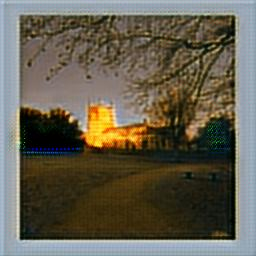

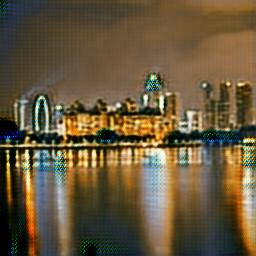

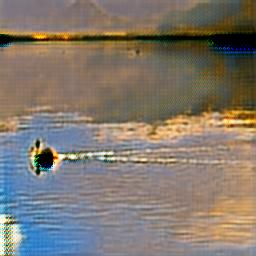

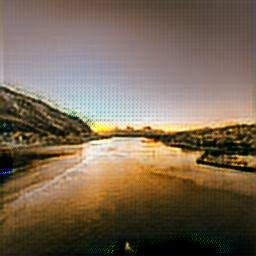

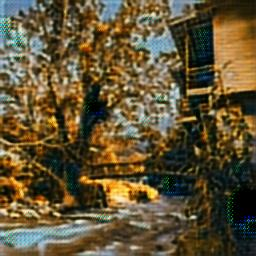

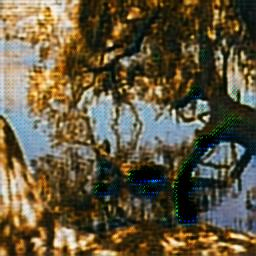

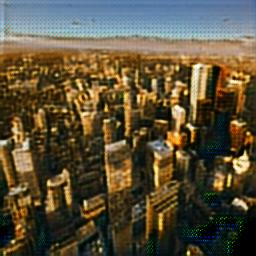

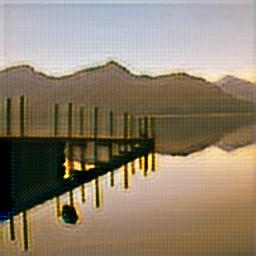

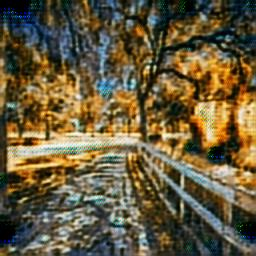

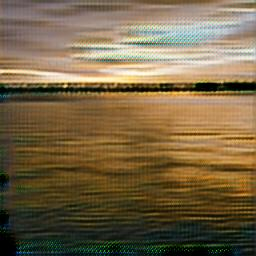

In [27]:
import os
from IPython.display import Image, display

# Define the path to the directory containing the images
image_directory = 'generated_images'

# List all files in the specified directory that are images
image_files = [f for f in os.listdir(image_directory) if f.endswith(('.jpg', '.png'))]

# Print the list of image files
print("Image files in '", image_directory, "':")
for img in image_files[:10]:
    display(Image(filename=os.path.join(image_directory, img)))

## Evaluation with MiFID

### Feature Extraction

In [28]:
from torch.utils.data import Dataset
from PIL import Image
import os

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')  # Convert to RGB to ensure 3 channels
        if self.transform:
            image = self.transform(image)
        return image

In [30]:
# Transform for input images
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load your datasets
real_dataset = CustomImageDataset(root_dir='/kaggle/input/gan-getting-started/photo_jpg', transform=transform)
generated_dataset = CustomImageDataset(root_dir='generated_images', transform=transform)

In [31]:
# Ensure you have the torchvision models imported
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the InceptionV3 model
inception_model = models.inception_v3(pretrained=True, transform_input=False)
# Adapt the model to return features from the pre-logit layer
inception_model.fc = torch.nn.Identity()
inception_model = inception_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 164MB/s] 


In [32]:
def extract_features(loader, model, device):
    model.eval()  # Set the model to evaluation mode
    features = []

    with torch.no_grad():  # No need to track gradients for feature extraction
        for images in loader:
            images = images.to(device)
            output = model(images)
            features.append(output.cpu().numpy())  # Move features to CPU and convert to numpy

    # Concatenate all features from all batches
    features = np.concatenate(features, axis=0)
    return features

In [33]:
from torch.utils.data import DataLoader

real_loader = DataLoader(real_dataset, batch_size=32, shuffle=False, num_workers=4)
generated_loader = DataLoader(generated_dataset, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [34]:
real_features = extract_features(real_loader, inception_model, device)
generated_features = extract_features(generated_loader, inception_model, device)

### Calculate FID value
Compute the Mean and Covariance: Calculate the mean and covariance of the feature vectors for both real and generated images.

Calculate FID Score: Use the mean and covariance of the real and generated images to calculate the FID score. The FID score measures the similarity between the two sets of images, where lower scores indicate more similarity.

In [35]:
from scipy.linalg import sqrtm
import numpy as np

def calculate_fid(real_features, generated_features):
    # Calculate mean and covariance statistics
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = generated_features.mean(axis=0), np.cov(generated_features, rowvar=False)

    # Compute the squared difference in means
    ssdiff = np.sum((mu1 - mu2) ** 2.0)

    # Compute the sqrt of the product of covariances
    covmean = sqrtm(sigma1.dot(sigma2))

    # Check for imaginary numbers and ignore them
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Calculate FID
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [36]:
fid_score = calculate_fid(real_features, generated_features)
print(f"FID score: {fid_score}")

FID score: 60.233192044473334


### Incorporate Memorization penalty into MiFID
Calculate Nearest Neighbor Distance: For each generated image, find the nearest neighbor in the feature space among the real images. This step assesses how closely the generated images resemble any single image in the training set.

Penalize Close Matches: Apply a penalty if the distance between a generated image and its nearest neighbor in the real dataset is below a certain threshold, indicating potential memorization.

Adjust FID Score: Incorporate the memorization penalty into the FID score to get the MiFID score. The specifics of how the penalty is applied can vary depending on the implementation or specific research work.

In [37]:
from scipy.spatial.distance import cdist
import numpy as np

def calculate_memorization_penalty(real_features, generated_features, threshold=0.1):
    """
    Calculate the memorization penalty based on the minimum distance
    between generated features and real features. A lower threshold
    indicates stricter penalty for similarity.

    :param real_features: Feature vectors of real images.
    :param generated_features: Feature vectors of generated images.
    :param threshold: Distance threshold for considering an image as memorized.
    :return: Memorization penalty score.
    """
    # Calculate pairwise distances between real and generated features
    distances = cdist(generated_features, real_features, metric='euclidean')

    # Find the minimum distance to real features for each generated feature
    min_distances = distances.min(axis=1)

    # Count how many generated features are too close to any real feature
    num_memorized = (min_distances < threshold).sum()

    # Calculate the penalty as the proportion of generated images considered memorized
    penalty = num_memorized / len(generated_features)

    return penalty


In [38]:
def calculate_mifid(fid_score, memorization_penalty, penalty_weight=10):
    """
    Adjust FID score with memorization penalty to get MiFID.

    :param fid_score: Original FID score.
    :param memorization_penalty: Calculated memorization penalty.
    :param penalty_weight: Weight of memorization penalty.
    :return: MiFID score.
    """
    # Integrate the memorization penalty with the FID score
    mifid_score = fid_score + penalty_weight * memorization_penalty
    return mifid_score

In [39]:
memorization_penalty = calculate_memorization_penalty(real_features, generated_features, threshold=0.1)
mifid_score = calculate_mifid(fid_score, memorization_penalty, penalty_weight=10)

print(f"Memorization Penalty: {memorization_penalty}")
print(f"MiFID score: {mifid_score}")

Memorization Penalty: 0.0
MiFID score: 60.233192044473334


## Final Interpretation
MiFID Score: A lower MiFID score indicates better performance, similar to FID, but with added consideration for penalizing memorization. This helps ensure that the model generates diverse and novel images rather than replicating or slightly altering existing ones.